# Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
import torch

# This line imports the LLM class from the llm module. LLM likely stands for "Language Model" or something similar.There was an llm.py file 
# Here from transformer from scratch called
from model.llm import LLM


# This code defines a Tokenizer class and a train_tokenizer function for tokenizing text data using SentencePiece, a library for unsupervised text tokenization. 
from model.tokenizer import Tokenizer, train_tokenizer



# This code defines a NextTokenPredictionDataset class for creating a dataset suitable for training a language model for next token prediction.
from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train

from helpers.config import LLMConfig, TrainingConfig, get_device


print(f"pytorch version: {torch.__version__}")

pytorch version: 2.1.2+cu121


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./data/tiny-shakespeare.txt
  input_format: 
  model_prefix: data/tiny-shakespeare
  model_type: UNIGRAM
  vocab_size: 100
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 1000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  di

# Set config


In [3]:
# llm_config and train_config are configuration objects used for configuring the language model (LLM) and the training process, respectively. 

llm_config = LLMConfig(
    # The size of the vocabulary used by the language model.
    vocab_size=2_000,
    # The size of the context window, i.e., the number of tokens considered as context for predicting the next token.
    context_size=64,
    # The dimensionality of the token embeddings.
    dim_emb=256,
    # The number of layers in the transformer architecture of the language model.
    num_layers=4,
    # The number of attention heads in the multi-head self-attention mechanism.
    num_heads=8,
    # The dropout probability applied to the token embeddings.
    emb_dropout=0.0,
    # The dimensionality of the hidden layer in the feedforward network within the transformer layers.
    ffd_dim_hidden=4 * 256,
    # A boolean indicating whether bias is used in the feedforward network within the transformer layers.
    ffd_bias=False,
)

train_config = TrainingConfig(
    retrain_tokenizer=False,
    device=get_device(),
    # The batch size used during training.
    batch_size=64,
    # The learning rate used for optimization during training.
    learning_rate=3e-4,
    weight_decay=1e-5,
    # The maximum number of training steps (or iterations) for which the training will run.
    max_steps=4000,
    # For example, if set to 1, logging will happen after each training step.
    log_frequency=1,
)

# Prepare tokenizer and dataset


In [4]:
# Read the .txt file and build a docker.model 

# Next we pass the output_file in Tokenizer function and we get an object file
 


input_file = "./data/tiny-shakespeare.txt"
output_file = Path(input_file).with_suffix(".model")
# print(output_file)

if not output_file.exists() or train_config.retrain_tokenizer:
    print("Hello")
    train_tokenizer(input_file, llm_config.vocab_size)

tokenizer = Tokenizer(str(output_file))
# We pass this in NextTokenPredictionDataset function

In [5]:
print(tokenizer.vocab_size)

100


In [6]:
# string="The quick brown fox jumps over the lazy dog."
# print(string)
# print(len(string))

sentence = (
    "Think you so, sir?"
)

ipt=tokenizer.sp.EncodeAsPieces(sentence)
print(ipt)
print(tokenizer.sp.DecodePieces(ipt))

# len(tokenizer.sp.EncodeAsIds(sentence))

['▁Th', 'in', 'k', '▁you', '▁', 's', 'o', ',', '▁', 's', 'i', 'r', '?']
Think you so, sir?


In [7]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
# NextTokenPredictionDataset is a helper class for generating batches of inputs and targets for training a language model.

ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)


X, y = ds_train.get_batch(batch_size=1)
print(X,y)
# The last element of y seems to be the token to predict next.
print(X.shape, y.shape)

tensor([[64,  4, 18, 14,  8, 12, 45,  4, 14,  8,  6,  5, 13, 67, 10,  6,  4, 15,
          8, 99, 14,  9, 59,  4, 69, 35, 25, 10, 99,  6, 13, 22, 16, 45,  4,  9,
         99, 33,  4,  6, 20,  8, 99, 14,  9,  4, 23, 11, 29,  9,  4, 65, 81,  4,
         38, 11, 63, 31, 12,  4,  7, 23,  7, 29]], dtype=torch.int32) tensor([[ 4, 18, 14,  8, 12, 45,  4, 14,  8,  6,  5, 13, 67, 10,  6,  4, 15,  8,
         99, 14,  9, 59,  4, 69, 35, 25, 10, 99,  6, 13, 22, 16, 45,  4,  9, 99,
         33,  4,  6, 20,  8, 99, 14,  9,  4, 23, 11, 29,  9,  4, 65, 81,  4, 38,
         11, 63, 31, 12,  4,  7, 23,  7, 29, 33]])
torch.Size([1, 64]) torch.Size([1, 64])


# Define model


In [8]:
model = LLM(
    vocab_size=tokenizer.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
    emb_dropout=llm_config.emb_dropout,
    ffd_hidden_dim=llm_config.ffd_dim_hidden,
    ffd_bias=llm_config.ffd_bias,
)

params_size = sum(p.nelement() * p.element_size() for p in model.parameters())
buffer_size = sum(p.nelement() * p.element_size() for p in model.buffers())
size = (params_size + buffer_size) / 1024**2

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"model size: {size:.3f}MB")

# print(model)

total params: 11,596,132
model size: 44.314MB


# Train model


In [9]:
loss_history = train(
    model,
    ds_train,
    train_config.device,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    weight_decay=train_config.weight_decay,
    log_every=train_config.log_frequency,
)

Training on cpu.


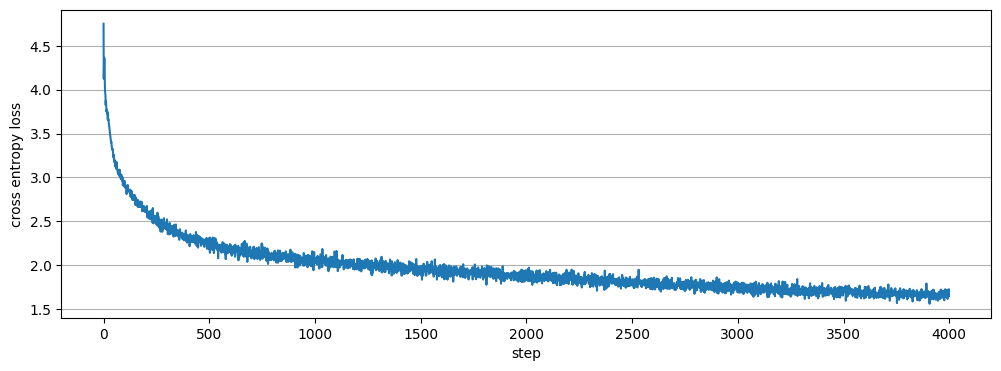

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

# Play around


In [11]:
# empty prompt to generate random stuff
prompt = torch.full((1, llm_config.context_size), tokenizer.pad_id, dtype=torch.int32).to(train_config.device)
out = model.generate(prompt, max_seq_len=30)
tokenizer.decode(out)

'her crowns one must shalt tread within o'

In [12]:
# generate from a prompt
prompt = (
    tokenizer.encode(
        "After I have done what I promised?",
        beg_of_string=True,
        pad_seq=True,
        seq_len=llm_config.context_size,
    )
    .view(1, -1)
    .to(train_config.device)
)
out = model.generate(prompt, max_seq_len=30)
print("\n")
tokenizer.decode(out)

'After I have done what I promised? PETRUCHIO: Why, my rog; you will sha'